In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras as K
import tensorflow as tf
import cv2
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score,mean_squared_error 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,array_to_img, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from skimage.transform import resize
from livelossplot import PlotLossesKeras
from chitra.image import Chitra
from mtcnn import MTCNN

In [2]:
df = pd.read_csv('./Dataset/train/train.csv')
df_box = pd.read_csv('./Dataset/train/Box_Data/bbox_train.csv')
#Y = df.drop('Name', axis=1)
df_box_single = df_box.drop_duplicates(subset=['Name'])


In [135]:
df_box_single['Category'] = 1
df_box_single.drop(['width','height'], axis = 1,inplace=True)
df_box_single

/var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/ipykernel_32879/4241691672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box_single['Category'] = 1


In [7]:
data = []
labels = []
bboxes = [np.array(df_box_single[['xmin','ymin','xmax','ymax']])]
imagePaths = []

In [ ]:
bboxes = bboxes[0]
bboxes[0]

array([192, 199, 230, 235])

rescaled bbox: [BoundingBox(x1=70.2745, y1=109.2549, x2=84.1830, y2=129.0196, label=Face)]


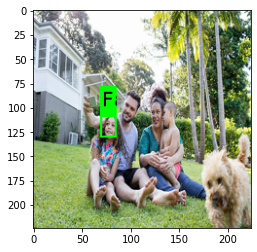

In [30]:
image = Chitra('./Dataset/train/image_data/Faces/10001.jpg', bboxes[0], 'Face')
# Chitra can rescale your bounding box automatically based on the new image size.
image.resize_image_with_bbox((224, 224))

print('rescaled bbox:', image.bboxes)
#plt.image(image.draw_boxes())
imgplot = plt.imshow(image.draw_boxes())
imgplot



In [46]:
test = []
test.append([image.bboxes[0][0][0],image.bboxes[0][0][1],image.bboxes[0][1][0],image.bboxes[0][1][1]])
test[0]

[70.27451, 109.254906, 84.18301, 129.0196]

In [34]:
def drawBox(boxes, image):
    for i in range(0, len(boxes)):
        # changed color and width to make it visible
        cv2.rectangle(image, (boxes[i], boxes[i]), (boxes[i], boxes[i]), (255, 0, 0), 1)
    cv2.imshow("img", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [41]:
drawBox(bboxes[0],train_data[0])

In [201]:
df

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4
...,...,...
5728,18201.jpg,2
5729,18203.jpg,3
5730,18204.jpg,5
5731,18205.jpg,8


In [27]:
print("non_trainable_weights:", len(res_model.layers))

non_trainable_weights: 177


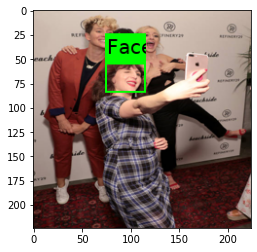

In [200]:
PATH = './Dataset/train/image_data/Faces/'
size = (224,224)
im_name = []
train_data = []
box_data = []
for  i,(name) in enumerate(df['Name']):
    image = Chitra(PATH + name, bboxes[i], 'Face')
    image.resize_image_with_bbox((224, 224))
    if image.numpy().shape != (224,224,3):
        df.drop(df[df['Name'] == name].index, inplace=True)
        continue
    train_data.append(image.numpy())
    temp = []
    temp.append([image.bboxes[0][0][0],image.bboxes[0][0][1],image.bboxes[0][1][0],image.bboxes[0][1][1]])
    box_data.append(temp[0])
    im_name.append(name)
train_data = np.array(train_data)
imgplot = plt.imshow(image.draw_boxes())
imgplot

In [73]:
input_t = K.Input(shape=(224, 224, 3))
res_model = K.applications.ResNet50 (include_top=True, weights="imagenet", input_tensor=input_t)
for layer in res_model.layers[:145]:
    layer.trainable = True

Metal device set to: Apple M1 Pro


2022-09-08 12:22:48.008898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-08 12:22:48.009033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [130]:
input_shape = (224, 224, 3)
input_layer = K.layers.Input(input_shape)
res_layer = res_model(input_layer)
train_layer = K.layers.Flatten()(res_layer)
train_layer = K.layers.BatchNormalization()(train_layer)
train_layer = K.layers.Dense(226, activation='relu')(train_layer)

classifier_branch = K.layers.Flatten()(train_layer)
classifier_branch = K.layers.BatchNormalization()(classifier_branch)
classifier_branch = K.layers.Dense(128, activation='relu', name='cl_1')(classifier_branch)
classifier_branch = K.layers.Dense(1, name='cl_head')(classifier_branch) 

locator_branch = K.layers.Flatten()(train_layer)
locator_branch = K.layers.BatchNormalization()(locator_branch)
locator_branch = K.layers.Dense(128, activation='relu', name='bb_1')(locator_branch)
locator_branch = K.layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = K.layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = K.layers.Dense(4, activation='relu', name='bb_head')(locator_branch)

In [131]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch,locator_branch])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 1000)         25636712    ['input_9[0][0]']                
                                                                                                  
 flatten_10 (Flatten)           (None, 1000)         0           ['resnet50[6][0]']               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 1000)        4000        ['flatten_10[0][0]']       

In [132]:
losses = {"cl_head":K.losses.categorical_crossentropy, "bb_head":K.losses.MSE}

In [133]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [95]:
#face_model.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], optimizer='Adam', loss = 'binary_crossentropy' )

In [199]:
df

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4
...,...,...
5728,18201.jpg,2
5729,18203.jpg,3
5730,18204.jpg,5
5731,18205.jpg,8


In [198]:
X = train_data
y = np.array(box_data)
print(X.shape)
print(y.shape)

(5725, 224, 224, 3)
(5725, 4)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.1, test_size = 0.03, random_state=10)
X_train.shape

(572, 224, 224, 3)

In [115]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(572, 224, 224, 3)
(172, 224, 224, 3)
(572, 4)
(172, 4)


In [83]:
checkpoint = K.callbacks.ModelCheckpoint("./Models/best_small_model.h5", save_best_only=True, monitor="val_loss"),

In [82]:
trainTargets = {
    "cl_head": df_box_single['Category'][0:571],
    "bb_head": y_train
}
validationTargets = {
    "cl_head": df_box_single['Category'][0:171],
    "bb_head": y_test
}

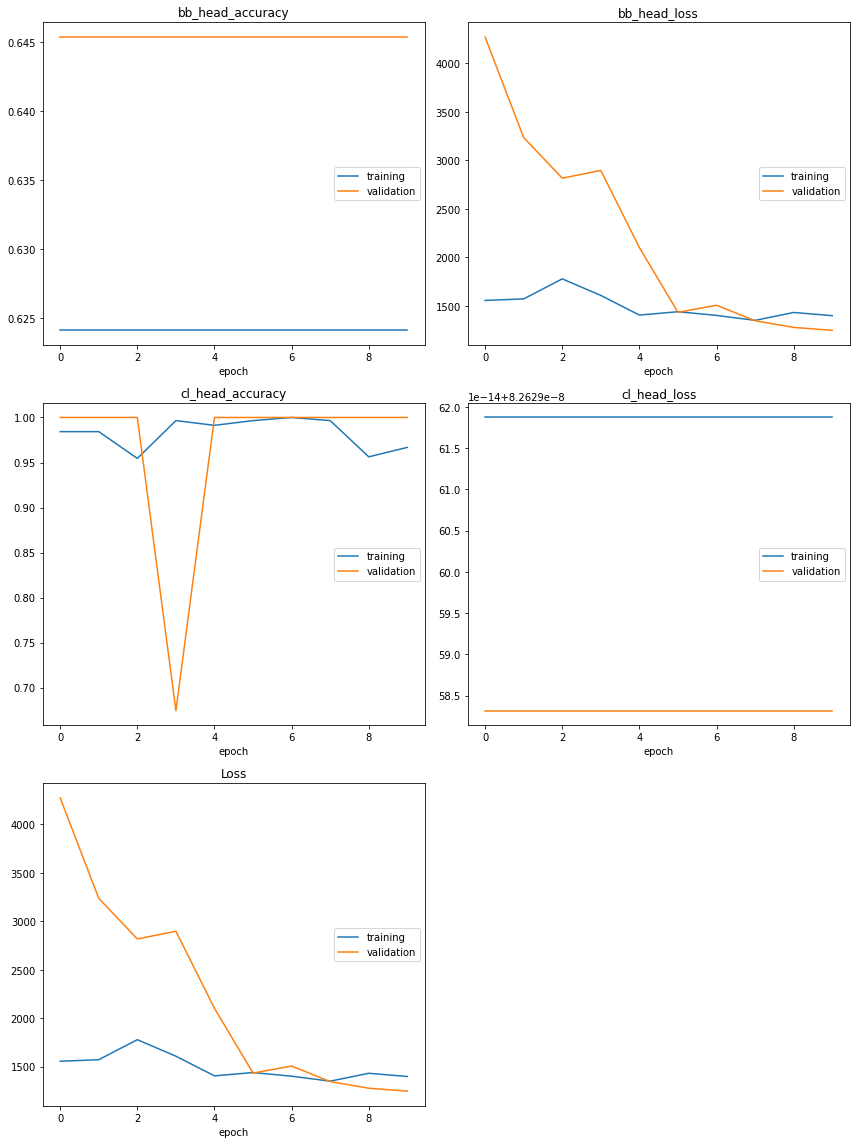

bb_head_accuracy
	training         	 (min:    0.624, max:    0.624, cur:    0.624)
	validation       	 (min:    0.645, max:    0.645, cur:    0.645)
bb_head_loss
	training         	 (min: 1350.495, max: 1778.377, cur: 1398.774)
	validation       	 (min: 1247.626, max: 4272.167, cur: 1247.626)
cl_head_accuracy
	training         	 (min:    0.955, max:    1.000, cur:    0.967)
	validation       	 (min:    0.674, max:    1.000, cur:    1.000)
cl_head_loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min: 1350.495, max: 1778.377, cur: 1398.774)
	validation       	 (min: 1247.626, max: 4272.167, cur: 1247.626)
36/36 [==============================] - 12s 325ms/step - loss: 1398.7743 - cl_head_loss: 8.2630e-08 - bb_head_loss: 1398.7743 - cl_head_accuracy: 0.9668 - bb_head_accuracy: 0.6241 - val_loss: 1247.6259 - val_cl_head_loss: 8.2630e-08 - val_bb_head_loss: 1247.6259 - val_cl_he

In [151]:
history = model.fit(X_train, [df_box_single['Category'][0:572],y_train],
             validation_data=(X_test, [df_box_single['Category'][0:172],y_test]),
             batch_size=16,
             epochs=10,
             shuffle=True,
             verbose=1,
             callbacks = [PlotLossesKeras(),checkpoint])

In [152]:
pred = model.predict(X_test)
pred

6/6 [==============================] - 1s 203ms/step


[array([[0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [1.1005192 ],
        [1.0664515 ],
        [0.6856333 ],
        [0.6869873 ],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.6878588 ],
        [1.0519034 ],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [1.4494762 ],
        [0.6857929 ],
        [0.68530655],
        [0.68530655],
        [0.68857044],
        [0.68530655],
        [0.68534017],
        [0.6853051 ],
        [0.68530655],
        [0.68530655],
        [0.6865179 ],
        [0.6877185 ],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.70579636],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0.68530655],
        [0

In [142]:
Bounds = np.mean()


31.05414

In [159]:
bound = [ 99.360855,  63.495235, 125.062096, 105.99143 ],

In [182]:
image = Chitra(X_test[1], [bound, y_test[1]], ['Face','Face'])
# Chitra can rescale your bounding box automatically based on the new image size.
image.resize_image_with_bbox((224, 224))

print('rescaled bbox:', image.bboxes)
#plt.image(image.draw_boxes())
imgplot = plt.imshow(image.draw_boxes())
imgplot

TypeError: BoundingBox.__init__() missing 2 required positional arguments: 'x2' and 'y2'

rescaled bbox: [BoundingBox(x1=147.5033, y1=84.0000, x2=162.5098, y2=115.2941, label=Face)]


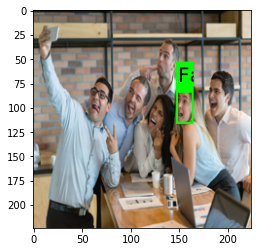

In [183]:
image = Chitra(X_test[1], y_test[1], 'Face')
# Chitra can rescale your bounding box automatically based on the new image size.
image.resize_image_with_bbox((224, 224))

print('rescaled bbox:', image.bboxes)
#plt.image(image.draw_boxes())
imgplot = plt.imshow(image.draw_boxes())
imgplot

In [165]:
detector = MTCNN()

In [206]:
counter = []
for i in X_test:
    boxes = detector.detect_faces(i)
    counter.append(len(boxes))
counter

1/1 [==============================] - 0s 19ms/step


[4,
 6,
 8,
 4,
 3,
 6,
 3,
 3,
 4,
 3,
 1,
 2,
 4,
 17,
 10,
 5,
 4,
 5,
 2,
 3,
 1,
 4,
 2,
 5,
 11,
 4,
 3,
 2,
 5,
 7,
 3,
 4,
 3,
 5,
 1,
 3,
 3,
 4,
 2,
 3,
 2,
 4,
 1,
 6,
 4,
 1,
 6,
 16,
 2,
 3,
 2,
 2,
 6,
 4,
 2,
 2,
 6,
 2,
 2,
 4,
 5,
 3,
 5,
 5,
 2,
 4,
 4,
 2,
 4,
 7,
 3,
 2,
 0,
 5,
 2,
 4,
 2,
 3,
 6,
 2,
 5,
 3,
 3,
 2,
 1,
 2,
 0,
 3,
 2,
 6,
 3,
 0,
 3,
 1,
 0,
 3,
 4,
 3,
 2,
 1,
 0,
 5,
 1,
 1,
 2,
 2,
 2,
 3,
 6,
 2,
 4,
 3,
 2,
 2,
 7,
 0,
 2,
 5,
 0,
 6,
 4,
 0,
 4,
 5,
 10,
 4,
 0,
 6,
 2,
 2,
 5,
 0,
 2,
 5,
 3,
 5,
 5,
 2,
 4,
 3,
 4,
 5,
 3,
 3,
 5,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 4,
 1,
 0,
 4,
 3,
 2,
 3,
 1,
 4,
 4,
 3,
 1,
 5,
 0,
 1,
 3,
 2,
 2]

In [207]:
mean_squared_error(counter,y_test,squared=False)

2.974699515800264

In [208]:
counter

[4,
 6,
 8,
 4,
 3,
 6,
 3,
 3,
 4,
 3,
 1,
 2,
 4,
 17,
 10,
 5,
 4,
 5,
 2,
 3,
 1,
 4,
 2,
 5,
 11,
 4,
 3,
 2,
 5,
 7,
 3,
 4,
 3,
 5,
 1,
 3,
 3,
 4,
 2,
 3,
 2,
 4,
 1,
 6,
 4,
 1,
 6,
 16,
 2,
 3,
 2,
 2,
 6,
 4,
 2,
 2,
 6,
 2,
 2,
 4,
 5,
 3,
 5,
 5,
 2,
 4,
 4,
 2,
 4,
 7,
 3,
 2,
 0,
 5,
 2,
 4,
 2,
 3,
 6,
 2,
 5,
 3,
 3,
 2,
 1,
 2,
 0,
 3,
 2,
 6,
 3,
 0,
 3,
 1,
 0,
 3,
 4,
 3,
 2,
 1,
 0,
 5,
 1,
 1,
 2,
 2,
 2,
 3,
 6,
 2,
 4,
 3,
 2,
 2,
 7,
 0,
 2,
 5,
 0,
 6,
 4,
 0,
 4,
 5,
 10,
 4,
 0,
 6,
 2,
 2,
 5,
 0,
 2,
 5,
 3,
 5,
 5,
 2,
 4,
 3,
 4,
 5,
 3,
 3,
 5,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 4,
 1,
 0,
 4,
 3,
 2,
 3,
 1,
 4,
 4,
 3,
 1,
 5,
 0,
 1,
 3,
 2,
 2]

In [205]:
y_test

772      4
3344     7
3332    24
596      4
4546    10
        ..
5309     4
5189     4
1976     3
3015     3
856      2
Name: HeadCount, Length: 172, dtype: int64

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X,df['HeadCount'], train_size=0.1, test_size = 0.03, random_state=10)
y_test

772      4
3344     7
3332    24
596      4
4546    10
        ..
5309     4
5189     4
1976     3
3015     3
856      2
Name: HeadCount, Length: 172, dtype: int64

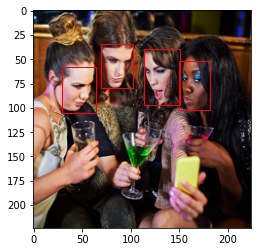

In [184]:
fig, ax = plt.subplots()
ax.imshow(X_test[0])
# Create a Rectangle patch
for i in boxes:
    box = i.get('box')
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [177]:

for i in boxes:
    i.get('box')


[29, 58, 35, 47]

In [164]:
#face_model.fit(X_train,y_train,batch_size=16,epochs = 10,verbose = 1, validation_data = (X_test,y_test),callbacks=[PlotLossesKeras(),checkpoint])

In [99]:
tf.config.run_functions_eagerly(True)

In [162]:
pred = face_model.predict(X_test)
accuracy_score(np.round(pred),y_test)

6/6 [==============================] - 1s 180ms/step


0.1511627906976744

In [144]:
test_image = tf.keras.preprocessing.image.load_img('./Dataset/train/image_data/Faces/10006.jpg')                
test_input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
test_input_arr_res = resize(test_input_arr,(224,224))
test_input_arr_res = np.array([test_input_arr_res])
pred = face_model.predict(test_input_arr_res)
pred

1/1 [==============================] - 0s 46ms/step


array([[3.4063344]], dtype=float32)

In [118]:
test_input_arr_res = np.array([[test_input_arr_res]])

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:
    {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

In [41]:
face_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 25,646,722
Trainable params: 25,593,602
Non-trainable params: 53,120
_________________________________________________________________


In [175]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath('./resnet50_coco_best_v2.1.0.h5')
detector.loadModel(res_model)

In [ ]:
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "/Users/sebastianbott/Documents/Development/Competitions/Competition_Face_Count/Dataset/train/image_data/Faces/17737.jpg"), output_image_path=os.path.join(execution_path , "./Dataset/train/image_data/Boxed/10001.jpg"))



In [ ]:
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='', save_format='jpeg'):
    i += 1
    if i > 20:
        break

In [28]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './Dataset/train/image_data/',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
'''validation_generator = test_datagen.flow_from_directory(
        './Dataset/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')'''



Found 0 images belonging to 0 classes.


"validation_generator = test_datagen.flow_from_directory(\n        './Dataset/validation',\n        target_size=(224, 224),\n        batch_size=batch_size,\n        class_mode='binary')"

In [ ]:
#def getImages(names):
PATH = './Dataset/train/image_data/Faces/'
size = (224,224)
train_data = []
box_data = []
for  name in df['Name']:
    image = tf.keras.preprocessing.image.load_img(PATH + name)                
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr_res = resize(input_arr,(224,224))
    train_data.append(input_arr_res)
train_data = np.array(train_data)
len(train_data)